# Part 6: Finetuning a Large Language ModelTo Follow Instructions

In [2]:
from importlib.metadata import version

pkgs = [
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.2
tiktoken version: 0.7.0
torch version: 2.4.0
tqdm version: 4.67.1
tensorflow version: 2.18.0


<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/overview.webp?1" width=820px>

## 6.1 Introduction to instruction finetuning

- In Lab 4, we saw that pretraining an LLM involves a training procedure where it learns to generate one word at a time
- Hence, a pretrained LLM is good at text completion, but it is not good at following instructions
- In this lab, we teach the LLM to follow instructions better

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/instruction-following.webp" width=700px>

- The topics covered in this lab are summarized in the figure below

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/part-overview-1.webp?1" width=700px>

## 6.2 Preparing a dataset for supervised instruction finetuning

- We will work with an instruction dataset I prepared for this lab.

In [3]:
import json
import jsonlines
import os
import urllib

In [4]:
! wget -q https://huggingface.co/datasets/grammarly/coedit/resolve/main/train.jsonl 

In [5]:
dataset_list = []

# create subset of dataset
with jsonlines.open('train.jsonl') as f:
    for line in f.iter():
        # if phrase in line['src'].split(":")[0]:
            dataset_list.append(line)

# Split data into training and test
dataset_list_train = dataset_list[800:6000]
dataset_list_test = dataset_list[:800]

print("Total number of examples:", len(dataset_list))
print("Number of examples in training set:", len(dataset_list_train))
print("Number of examples in the test set:", len(dataset_list_test))


Total number of examples: 69071
Number of examples in training set: 5200
Number of examples in the test set: 800


In [6]:
def create_data_item(preamble, user_message, chatbot_message):
    formatted_data = {
        "instruction": preamble,
        "input": user_message,
        "output": chatbot_message,
    }
    return formatted_data

def create_json_from_list(file_name, dataset_segment, preamble):
    formatted_list = []
    for item in dataset_segment:
        user_message = item["src"]
        chatbot_message = item["tgt"]
        formatted_data = create_data_item(preamble, user_message, chatbot_message)
        formatted_list.append(formatted_data)

    # Write list to JSON file
    with open(f'{file_name}.json', 'w') as file:
        json.dump(formatted_list, file, indent=4)

# Use the function
preamble = "You are a writing assistant that helps the user write better English."
file_name = "english_train"
# assuming dataset_list_train is already defined and it is the list of records
create_json_from_list(file_name, dataset_list_train, preamble)

- Each item in the `data` list we loaded from the JSON file above is a dictionary in the following form

In [7]:
def load_file(file_path):
   with open(f'{file_path}.json', "r", encoding="utf-8") as file:
        data = json.load(file)
   return data


file_path = "english_train"
data = load_file(file_path)
print("Number of entries:", len(data))

Number of entries: 5200


In [8]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'You are a writing assistant that helps the user write better English.', 'input': 'Improve the grammaticality of this sentence: All this will eventually lead to suicide and depression among the elderly.', 'output': 'All this could eventually lead to suicide and depression among the elderly.'}


- Note that the `'input'` field can be empty:

In [9]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': 'You are a writing assistant that helps the user write better English.', 'input': 'Remove grammar mistakes: As people are having a higher life expectancy today, more spending is expected to provide better healthcare facilities and other services for the aged.', 'output': 'As people are enjoying higher life expectancy today, more spending is expected to provide better healthcare facilities and other services for the aged.'}


- Instruction finetuning is often referred to as "supervised instruction finetuning" because it involves training a model on a dataset where the input-output pairs are explicitly provided
- There are different ways to format the entries as inputs to the LLM; the figure below illustrates two example formats that were used for training the Alpaca (https://crfm.stanford.edu/2023/03/13/alpaca.html) and Phi-3 (https://arxiv.org/abs/2404.14219) LLMs, respectively

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/prompt-style.webp?1" width=700px>

- In this lab, we use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning.
- Below, we format the input that we will pass as input to the LLM

In [10]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- A formatted response with input field looks like as shown below

In [11]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
You are a writing assistant that helps the user write better English.

### Input:
Improve the grammaticality of this sentence: All this will eventually lead to suicide and depression among the elderly.

### Response:
All this could eventually lead to suicide and depression among the elderly.


- Below is a formatted response without an input field

In [12]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
You are a writing assistant that helps the user write better English.

### Input:
Remove grammar mistakes: As people are having a higher life expectancy today, more spending is expected to provide better healthcare facilities and other services for the aged.

### Response:
As people are enjoying higher life expectancy today, more spending is expected to provide better healthcare facilities and other services for the aged.


- Lastly, before we prepare the PyTorch data loaders in the next section, we divide the dataset into a training, validation, and test set

In [13]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [14]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 4420
Validation set length: 260
Test set length: 520


## 6.3 Organizing data into training batches

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/part-overview-2.webp?1" width=700px>

- We tackle this dataset batching in several steps, as summarized in the figure below

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/detailed-batching.webp?1" width=700px>

- First, we implement an `InstructionDataset` class that pre-tokenizes all inputs in the dataset, similar to the `SpamDataset` in part 5

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/pretokenizing.webp" width=700px>

In [15]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

- Similar to part 5, we want to collect multiple training examples in a batch to accelerate training; this requires padding all inputs to a similar length
- Also similar to the previous lab, we use the `<|endoftext|>` token as a padding token

In [16]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- In part 5, we padded all examples in a dataset to the same length
  - Here, we take a more sophisticated approach and develop a custom "collate" function that we can pass to the data loader
  - This custom collate function pads the training examples in each batch to have the same length (but different batches can have different lengths)

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/padding.webp" width=700px>

In [17]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [18]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/batching-step-4.webp?1" width=600px>

- Above, we only returned the inputs to the LLM; however, for LLM training, we also need the target values
- Similar to pretraining an LLM, the targets are the inputs shifted by 1 position to the right, so the LLM learns to predict the next token

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/inputs-targets.webp?1" width=600px>

In [19]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [20]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


- Next, we introduce an `ignore_index` value to replace all padding token IDs with a new value; the purpose of this `ignore_index` is that we can ignore padding values in the loss function (more on that later)

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/batching-step-5.webp?1" width=600px>

- Concretely, this means that we replace the token IDs corresponding to `50256` with `-100` as illustrated below

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/ignore-index.webp?1" width=800px>

- (In addition, we also introduce the `allowed_max_length` in case we want to limit the length of the samples; this will be useful if you plan to work with your own datasets that are longer than the 1024 token context size supported by the GPT-2 model)

In [21]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [22]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


- Let's see what this replacement by -100 accomplishes
- For illustration purposes, let's assume we have a small classification task with 2 class labels, 0 and 1, similar to part 6
- If we have the following logits values (outputs of the last layer of the model), we calculate the following loss

In [23]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


- Now, adding one more training example will, as expected, influence the loss

In [24]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


- Let's see what happens if we replace the class label of one of the examples with -100

In [25]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- As we can see, the resulting loss on these 3 training examples is the same as the loss we calculated from the 2 training examples, which means that the cross-entropy loss function ignored the training example with the -100 label
- By default, PyTorch has the `cross_entropy(..., ignore_index=-100)` setting to ignore examples corresponding to the label -100
- Using this -100 `ignore_index`, we can ignore the additional end-of-text (padding) tokens in the batches that we used to pad the training examples to equal length
- However, we don't want to ignore the first instance of the end-of-text (padding) token (50256) because it can help signal to the LLM when the response is complete

- In practice, it is also common to mask out the target token IDs that correspond to the instruction, as illustrated in the figure below (this is a recommended reader Example after completing the part)

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/mask-instructions.webp?1" width=800px>

## 6.4 Creating data loaders for an instruction dataset

- In this section, we use the `InstructionDataset` class and `custom_collate_fn` function to instantiate the training, validation, and test data loaders

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/part-overview-3.webp?1" width=600px>

- Another additional detail of the previous `custom_collate_fn` function is that we now directly move the data to the target device (e.g., GPU) instead of doing it in the main training loop, which improves efficiency because it can be carried out as a background process when we use the `custom_collate_fn` as part of the data loader
- Using the `partial` function from Python's `functools` standard library, we create a new function with the `device` argument of the original function pre-filled

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print("Device:", device)

Device: mps


In [27]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

- Next, we instantiate the data loaders similar to previous labs, except that we now provide our own collate function for the batching process

In [28]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [29]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- Let's see what the dimensions of the resulting input and target batches look like

In [30]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 144]) torch.Size([8, 144])
torch.Size([8, 119]) torch.Size([8, 119])
torch.Size([8, 122]) torch.Size([8, 122])
torch.Size([8, 131]) torch.Size([8, 131])
torch.Size([8, 114]) torch.Size([8, 114])
torch.Size([8, 125]) torch.Size([8, 125])
torch.Size([8, 118]) torch.Size([8, 118])
torch.Size([8, 119]) torch.Size([8, 119])
torch.Size([8, 130]) torch.Size([8, 130])
torch.Size([8, 130]) torch.Size([8, 130])
torch.Size([8, 111]) torch.Size([8, 111])
torch.Size([8, 139]) torch.Size([8, 139])
torch.Size([8, 135]) torch.Size([8, 135])
torch.Size([8, 111]) torch.Size([8, 111])
torch.Size([8, 118]) torch.Size([8, 118])
torch.Size([8, 112]) torch.Size([8, 112])
torch.Size([8, 116]) torch.Size([8, 116])
torch.Size([8, 130]) torch.Size([8, 130])
torch.Size([8, 150]) torch.Size([8, 150])
torch.Size([8, 127]) torch.Size([8, 127])
torch.Size([8, 130]) torch.Size([8, 130])
torch.Size([8, 129]) torch.Size([8, 129])
torch.Size([8, 138]) torch.Size([8, 138])
torch.Size([8, 116])

- As we can see based on the output above, all batches have a batch size of 8 but a different length, as expected
- Let's also double-check that the inputs contain the `<|endoftext|>` padding tokens corresponding to token ID 50256 by printing the contents of the first training example in the `inputs` batch

In [31]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198,  1639,   389,   257,  3597,  8796,   326,
         5419,   262,  2836,  3551,  1365,  3594,    13,   198,   198, 21017,
        23412,    25,   198, 12050,   262,  6827, 14599, 44935,    25,  1114,
         4554,    11,  5735,  9503, 15129,   636,    12,  2435,  3946,    11,
          543,   466,   407,  2421,   262,  3259,   284,   307,   287,   262,
        15383,    11,   318,   922,   284,   307,  9177, 26760,    11,   416,
         1724,   286,   674,  6190,  3037,    13,   198,   198, 21017, 18261,
           25,   198,  1890,  4554,    11,  5735,  9503, 15129,   636,    12,
         2435,  3946,    11,   543,   466,   407,  2421,   262,  3259,   284,
          307,   287,   262, 15383,    11,   389,   922,   284,   307,  9177,
        26760,   416,  1724,   286,   674,  6190,  3037,    13, 

- Similarly, we visually double-check that the targets contain the -100 placeholder tokens

In [32]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198,  1639,   389,   257,  3597,  8796,   326,  5419,
          262,  2836,  3551,  1365,  3594,    13,   198,   198, 21017, 23412,
           25,   198, 12050,   262,  6827, 14599, 44935,    25,  1114,  4554,
           11,  5735,  9503, 15129,   636,    12,  2435,  3946,    11,   543,
          466,   407,  2421,   262,  3259,   284,   307,   287,   262, 15383,
           11,   318,   922,   284,   307,  9177, 26760,    11,   416,  1724,
          286,   674,  6190,  3037,    13,   198,   198, 21017, 18261,    25,
          198,  1890,  4554,    11,  5735,  9503, 15129,   636,    12,  2435,
         3946,    11,   543,   466,   407,  2421,   262,  3259,   284,   307,
          287,   262, 15383,    11,   389,   922,   284,   307,  9177, 26760,
          416,  1724,   286,   674,  6190,  3037,    13, 50256, 

## 6.5 Loading a pretrained LLM

- In this section, we load a pretrained GPT model using the same code that we used in section 5.5 of part 5 and section 6.4 in part 6

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/part-overview-4.webp?1" width=700px>

- However, instead of loading the smallest 124 million parameter model, we load the medium version with 355 million parameters since the 124 million model is too small for achieving qualitatively reasonable results via instruction finetuning

In [33]:
from gpt_download import download_and_load_gpt2
from previous_parts import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="../../gpt2/"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: ../../gpt2/355M/checkpoint
File already exists and is up-to-date: ../../gpt2/355M/encoder.json
File already exists and is up-to-date: ../../gpt2/355M/hparams.json
File already exists and is up-to-date: ../../gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: ../../gpt2/355M/model.ckpt.index
File already exists and is up-to-date: ../../gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: ../../gpt2/355M/vocab.bpe


- Before we start finetuning the model in the next section, let's see how it performs on one of the validation tasks

In [34]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
You are a writing assistant that helps the user write better English.

### Input:
Fix errors in this text: Some of those who receive positive testing result, despite the shock and the devastating situation that they face, will consider the interests of other family members and inform their relatives of the existence of this genetic risk in the family.


In [35]:
from previous_parts import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=100,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

- Note that the `generate` function we used in previous parts returns the combined input and output text, which was convenient in the previous section for creating legible text
- To isolate the response, we can subtract the length of the instruction from the start of the `generated_text`

In [36]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

### Output:

The user is now able to write better English.

### Conclusion:

The user is now able to write better English.

### Conclusion:

The user is now able to write better English.

### Conclusion:

The user is now able to write better English.

### Conclusion:

The user is now able to write better English.

### Conclusion:

The user is now able to write better


- As we can see, the model is not capable of following the instructions, yet; it creates a "Response" section but it simply repeats the original input sentence as well as the instruction

## 6.6 Finetuning the LLM on instruction data

- In this section, we finetune the model

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/part-overview-5.webp?1" width=700px>

- Note that we can reuse all the loss calculation and training functions that we used in previous parts

In [37]:
from previous_parts import (
    calc_loss_loader,
    train_model_simple
)

- Let's calculate the initial training and validation set loss before we start training (as in previous parts, the goal is to minimize the loss)

In [38]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.2833580017089843
Validation loss: 3.301569128036499


- The runtimes for various devices are shown for reference below (running this notebook on a compatible GPU device requires no changes to the code)

<div style="text-align: left;">
    
| Model              | Device                | Runtime for 2 Epochs |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 minutes        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 minutes        |
| gpt2-medium (355M) | GPU (L4)              | 1.83 minutes         |
| gpt2-medium (355M) | GPU (A100)            | 0.86 minutes         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 minutes         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 minutes         |
| gpt2-small (124M)  | GPU (L4)              | 0.69 minutes         |
| gpt2-small (124M)  | GPU (A100)            | 0.39 minutes         |

</div>

- I ran this notebook using the `"gpt2-medium (355M)"` model

In [39]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.611, Val loss 2.645
Ep 1 (Step 000005): Train loss 1.226, Val loss 1.359
Ep 1 (Step 000010): Train loss 1.048, Val loss 1.190
Ep 1 (Step 000015): Train loss 1.016, Val loss 1.174
Ep 1 (Step 000020): Train loss 1.004, Val loss 1.129
Ep 1 (Step 000025): Train loss 1.000, Val loss 1.111
Ep 1 (Step 000030): Train loss 0.897, Val loss 1.104
Ep 1 (Step 000035): Train loss 0.932, Val loss 1.092
Ep 1 (Step 000040): Train loss 0.951, Val loss 1.081
Ep 1 (Step 000045): Train loss 0.914, Val loss 1.082
Ep 1 (Step 000050): Train loss 0.998, Val loss 1.092
Ep 1 (Step 000055): Train loss 0.955, Val loss 1.095
Ep 1 (Step 000060): Train loss 0.968, Val loss 1.098
Ep 1 (Step 000065): Train loss 0.899, Val loss 1.077
Ep 1 (Step 000070): Train loss 0.976, Val loss 1.071
Ep 1 (Step 000075): Train loss 0.923, Val loss 1.069
Ep 1 (Step 000080): Train loss 0.909, Val loss 1.080
Ep 1 (Step 000085): Train loss 0.909, Val loss 1.078
Ep 1 (Step 000090): Train loss 0.877, Val loss

- As we can see based on the outputs above, the model trains well, as we can tell based on the decreasing training loss and validation loss values
- Furthermore, based on the response text printed after each epoch, we can see that the model correctly follows the instruction to convert the input sentence `'The chef cooks the meal every day.'` into passive voice `'The meal is cooked every day by the chef.'` (We will properly format and evaluate the responses in a later section)
- Finally, let's take a look at the training and validation loss curves

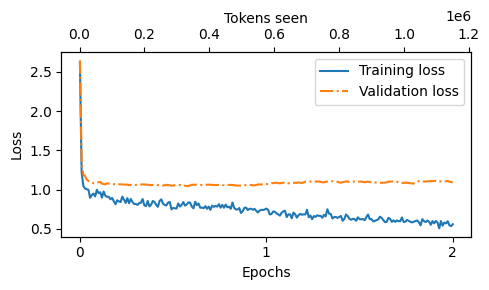

In [40]:
from previous_parts import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- As we can see, the loss decreases sharply at the beginning of the first epoch, which means the model starts learning quickly
- We can see that slight overfitting sets in at around 1 training epoch

## 6.7 Extracting and saving responses

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/part-overview-6.webp?1" width=500px>

- In this section, we save the test set responses for scoring in the next section
- We also save a copy of the model for future use
- But first, let's take a brief look at the responses generated by the finetuned model

In [41]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
You are a writing assistant that helps the user write better English.

### Input:
Remove all grammatical errors from this text: The overall plant efficiency of the VHTR is also greater than that of a MSR.

Correct response:
>> The overall plant efficiency of the VHTR is also greater than that of an MSR.

Model response:
>> The overall plant efficiency of the VHTR is also greater than that of a MSR.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
You are a writing assistant that helps the user write better English.

### Input:
Make the sentence fluent: The attractive feature of this MSR fuel cycle is that the fission products has shorter-lived radioactivity.

Correct response:
>> The attractive feature of this MSR fuel cycle is that the fission products

- As we can see based on the test set instructions, given responses, and the model's responses, the model performs relatively well
- The answers to the first and last instructions are clearly correct
- The second answer is close; the model answers with "cumulus cloud" instead of "cumulonimbus" (however, note that cumulus clouds can develop into cumulonimbus clouds, which are capable of producing thunderstorms)
- Most importantly, we can see that model evaluation is not as straightforward as in the previous part, where we just had to calculate the percentage of correct spam/non-spam class labels to obtain the classification accuracy
- In practice, instruction-finetuned LLMs such as chatbots are evaluated via multiple approaches
  - short-answer and multiple choice benchmarks such as MMLU ("Measuring Massive Multitask Language Understanding", [https://arxiv.org/abs/2009.03300](https://arxiv.org/abs/2009.03300)), which test the knowledge of a model
  - human preference comparison to other LLMs, such as LMSYS chatbot arena ([https://arena.lmsys.org](https://arena.lmsys.org))
  - automated conversational benchmarks, where another LLM like GPT-4 is used to evaluate the responses, such as AlpacaEval ([https://tatsu-lab.github.io/alpaca_eval/](https://tatsu-lab.github.io/alpaca_eval/))

- In the next section, we will use an approach similar to AlpacaEval and use another LLM to evaluate the responses of our model; however, we will use our own test set instead of using a publicly available benchmark dataset
- For this, we add the model response to the `test_data` dictionary and save it as a `"instruction-data-with-response.json"` file for record-keeping so that we can load and analyze it in separate Python sessions if needed

In [42]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 520/520 [13:23<00:00,  1.55s/it]


- Let's double-check one of the entries to see whether the responses have been added to the `test_data` dictionary correctly

In [43]:
print(test_data[0])

{'instruction': 'You are a writing assistant that helps the user write better English.', 'input': 'Remove all grammatical errors from this text: The overall plant efficiency of the VHTR is also greater than that of a MSR.', 'output': 'The overall plant efficiency of the VHTR is also greater than that of an MSR.', 'model_response': 'The overall plant efficiency of the VHTR is also greater than that of a MSR.'}


- Finally, we also save the model in case we want to reuse it in the future

In [50]:
import re

# Define the path
path = "../../gpt2/"

file_name = f"{path}{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
model.load_state_dict(torch.load(file_name))

Model saved as ../../gpt2/gpt2-medium355M-sft.pth


/var/folders/b4/twk1kqn144z6m04fvtpv4n2h0000gn/T/ipykernel_32351/7499108.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_name))


<All keys matched successfully>

## 6.8 Evaluating the finetuned LLM

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/part-overview-7.webp?1" width=500px>

- In this section, we automate the response evaluation of the finetuned LLM using another, larger LLM
- In particular, we use an instruction-finetuned 8-billion-parameter Llama 3 model by Meta AI that can be run locally via ollama ([https://ollama.com](https://ollama.com))
- (Alternatively, if you prefer using a more capable LLM like GPT-4 via the OpenAI API, please see the [llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb) notebook)

- Ollama is an application to run LLMs efficiently
- It is a wrapper around llama.cpp ([https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp)), which implements LLMs in pure C/C++ to maximize efficiency
- Note that it is a tool for using LLMs to generate text (inference), not training or finetuning LLMs
- Before running the code below, install ollama by visiting [https://ollama.com](https://ollama.com) and following the instructions (for instance, clicking on the "Download" button and downloading the ollama application for your operating system)

- For macOS and Windows users, click on the ollama application you downloaded; if it prompts you to install the command line usage, say "yes"
- Linux users can use the installation command provided on the ollama website

- In general, before we can use ollama from the command line, we have to either start the ollama application or run `ollama serve` in a separate terminal

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/ollama-run.webp?1" width=700px>


- With the ollama application or `ollama serve` running in a different terminal, on the command line, execute the following command to try out the 3-billion-parameter Llama 3 model (the model, which takes up 4.7 GB of storage space, will be automatically downloaded the first time you execute this command)

```bash
# 3B model
ollama run llama3.2
```


The output looks like as follows

```
$ ollama run llama3.2
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```

- Note that `llama3.2` refers to the finetuned 3-billion-parameter Llama 3.2 model

- Using ollama with the `"llama3.2"` model (a 3B parameter model) requires 16 GB of RAM; if this is not supported by your machine, you can try the smaller model, such as the 3.8B parameter phi-3 model by setting `model = "phi-3"`, which only requires 8 GB of RAM

- Alternatively, you can also use the larger 70-billion-parameter Llama 3 model, if your machine supports it, by replacing `llama3` with `llama3:70b`

- After the download has been completed, you will see a command line prompt that allows you to chat with the model

- Try a prompt like "What do llamas eat?", which should return an output similar to the following

```
>>> What do llamas eat?
Llamas are herbivores, which means they primarily eat plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including timothy grass, orchard grass, and ryegrass.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is an important part of a llama's diet.
3. Grains: Llamas may also be fed grains like oats, corn, or barley, but these should not make up more than 10-15% of their diet.
4. Fruits and vegetables: Fresh fruits and vegetables, like apples, carrots, and sweet potatoes, can be given as treats or added to their hay.
5. Browse: Llamas may also browse on shrubs, trees, and other vegetation, especially in the wild.

It's essential to provide llamas with a balanced diet that includes a mix of these food sources. A good rule of thumb is to provide:

* 80-90% of their diet as hay
* 5-10% as grains
* 1-2% as fruits and vegetables

Avoid feeding llamas foods that are high in sugar, fat, or salt, such as candy, chocolate, or processed snacks. A well-balanced diet will help keep your 
llama healthy and happy!

>>> Send a message (/? for help)
```

- You can end this session using the input `/bye`

- The following code checks whether the ollama session is running correctly before proceeding to use ollama to evaluate the test set responses we generated in the previous section

In [51]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [52]:
# This cell is optional; it allows you to restart the notebook
# and only run section 6.7 without rerunning any of the previous code
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- Now, an alternative way to the `ollama run` command we used earlier to interact with the model is via its REST API in Python via the following function
- Before you run the next cells in this notebook, make sure that ollama is still running (the previous code cells should print `"Ollama running: True"`)
- Next, run the following code cell to query the model

In [53]:
import urllib.request

def query_model(
    prompt,
    model="llama3.2",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3.2"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily eat plants and plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and grassy weeds.
2. Hay: High-quality hay, such as timothy hay or alfalfa hay, is a staple in a llama's diet. It provides essential nutrients like fiber, protein, and vitamins.
3. Grains: Llamas may also be fed grains like oats, barley, or corn, but these should not make up more than 10% of their diet.
4. Fruits and vegetables: Fresh fruits and vegetables, such as apples, carrots, and sweet potatoes, can be given to llamas as treats or added to their hay.
5. Browse: Llamas may also eat browse, which includes leaves, twigs, and other vegetation from trees and shrubs.

It's essential to note that llamas have a unique digestive system, with a four-chambered stomach, which allows them to break down and extract nutrients from plant material more efficiently than many other 

- Now, using the `query_model` function we defined above, we can evaluate the responses of our finetuned model; let's try it out on the first 3 test set responses we looked at in a previous section

In [54]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The overall plant efficiency of the VHTR is also greater than that of an MSR.

Model response:
>> The overall plant efficiency of the VHTR is also greater than that of a MSR.

Score:
>> ### Corrected Text:
The overall plant efficiency of the VHTR is also greater than that of an MSR.

### Score: 90/100

The corrected text is grammatically correct and conveys the same meaning as the original input. The only change made was adding the definite article "an" before "MSR", which is a common rule in English grammar to indicate that the noun is singular and not preceded by a consonant.

The score of 90/100 indicates that the model response is almost perfect, with only a minor adjustment needed to ensure grammatical correctness.

-------------------------

Dataset response:
>> The attractive feature of this MSR fuel cycle is that the fission products have shorter-lived radioactivity.

Model response:
>> The attractive feature of this MSR fuel cycle is that the fission prod

- As we can see, the Llama 3.2 model provides a reasonable evaluation and also gives partial points if a model is not entirely correct, as we can see based on the "cumulus cloud" answer
- Note that the previous prompt returns very verbose evaluations; we can tweak the prompt to generate integer responses in the range between 0 and 100 (where 100 is best) to calculate an average score for our model
- The evaluation of the 110 entries in the test set takes about 30 Seconds on an M3 MacBook Pro laptop

In [55]:
def generate_model_scores(json_data, json_key, model="llama3.2"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:   0%|▌                                                                                                                                                 | 2/520 [00:00<03:20,  2.59it/s]

Could not convert score: I would rate the model response as 80. The correction adds an article "an" before "MSR", which improves clarity and grammatical correctness. However, it's not perfect, as the original sentence could be rephrased for better flow and precision.


Scoring entries:   1%|█▋                                                                                                                                                | 6/520 [00:02<03:39,  2.34it/s]

Could not convert score: 80

Explanation: The corrected response improves grammatical correctness by adding a comma after "1977" for proper date formatting and changing "witnessed" to "saw" for subject-verb agreement. However, it still contains minor errors such as missing articles ("the") and incorrect punctuation.


Scoring entries:   2%|██▏                                                                                                                                               | 8/520 [00:02<03:08,  2.71it/s]

Could not convert score: 80

The corrected response is grammatically correct and properly punctuated. The error was a missing comma after "planes" to separate the introductory phrase from the main clause.


Scoring entries:   3%|████▍                                                                                                                                            | 16/520 [00:04<02:04,  4.03it/s]

Could not convert score: 80

The corrected text has removed the unnecessary apostrophe in "stages" and added it to make the sentence grammatically correct.


Scoring entries:   4%|█████▊                                                                                                                                           | 21/520 [00:05<02:17,  3.62it/s]

Could not convert score: 80

Explanation: The original sentence had two grammatical errors: "on" should be replaced with "in", and "by" should be replaced with "of". The corrected output was provided as per the instruction.


Scoring entries:   4%|██████▍                                                                                                                                          | 23/520 [00:07<04:36,  1.79it/s]

Could not convert score: I would give the corrected sentence a score of 80.

The original sentence had two grammatical mistakes: 

1. Missing comma after "cost"
2. Incorrect plural form of "maintenance cost" (should be "maintenance costs")

The corrected sentence is clear and concise, but it's not perfect. The phrase "a nuclear plant can achieve" seems out of place in the context of the sentence, which appears to be discussing energy output. A more accurate completion might include a specific type of energy source or technology.


Scoring entries:   5%|██████▉                                                                                                                                          | 25/520 [00:07<03:13,  2.56it/s]

Could not convert score: 80

Explanation: The corrected sentence has proper punctuation after "percent" and a comma before "which".


Scoring entries:   5%|███████▌                                                                                                                                         | 27/520 [00:08<03:02,  2.71it/s]

Could not convert score: 80

The corrected sentence has one minor error: "processes" should be "process". The model response is close but not perfect, which is why it scores 80 instead of 100.


Scoring entries:   7%|█████████▊                                                                                                                                       | 35/520 [00:10<02:57,  2.73it/s]

Could not convert score: 80

The corrected sentence has improved grammar, spelling, and punctuation, but there are still some minor errors:

- "Comparing" should be "When the amount of gases produced by fossil fuels is compared"
- "energy purpose" should be "energy purposes"
- Added a comma after "plants"

However, the model response was not perfect, hence the score 80.


Scoring entries:   8%|███████████▋                                                                                                                                     | 42/520 [00:12<03:03,  2.60it/s]

Could not convert score: 80

The corrected response has two minor errors: 

1. "soaring new heights" should be "soaring to new heights"
2. "fossil fuel" should be "fossil fuels"

These corrections improve the clarity and accuracy of the sentence, making it a better representation of the original instruction.


Scoring entries:   9%|█████████████                                                                                                                                    | 47/520 [00:13<02:42,  2.92it/s]

Could not convert score: 80

The corrected sentence has improved grammar, punctuation, and clarity. The original response was missing an apostrophe in "is" and had incorrect verb conjugation ("are" instead of "is"). The corrected response also added a comma after "than" for better sentence structure and flow.


Scoring entries:  11%|████████████████▍                                                                                                                                | 59/520 [00:16<02:11,  3.50it/s]

Could not convert score: 80

The corrected text should be "the" instead of "the America", as "America" is a country and cannot possess or not possess something. The correct response is:

Since 1986 when the Chornobyl accident happened, the America has not set up any new nuclear power plants.


Scoring entries:  12%|██████████████████▏                                                                                                                              | 65/520 [00:17<02:16,  3.34it/s]

Could not convert score: 80

The corrected text removes the unnecessary article "a" before "hazard industrial plant", adds the word "potential" to describe hazards, and changes "shifts system" to "shift system".


Scoring entries:  13%|██████████████████▋                                                                                                                              | 67/520 [00:19<04:36,  1.64it/s]

Could not convert score: 80

The corrected sentence "Without any of the above measures of human resource management, it will not be easy to ensure the reliability of the whole system." is grammatically correct and clear in its meaning.

The model response "Without any of the above measures of human resource management, the reliability of the whole system would not be easy to be assured." has a few errors:

- The verb tense is incorrect. The sentence should use the present perfect continuous tense ("would not be easy to be assured") instead of the simple future tense ("would not be easy to be assured").
- The word "assured" is not in the correct form. It should be "ensured" (the past participle of "ensure").

Therefore, the score is 80, indicating a good but not perfect response.


Scoring entries:  14%|███████████████████▊                                                                                                                             | 71/520 [00:21<02:54,  2.57it/s]

Could not convert score: 60

The corrected sentence should have "above-mentioned" instead of "above mentioned", and "less than" instead of "less". The original response was missing an apostrophe in "above mentioned" and used "less" instead of "less than".


Scoring entries:  15%|██████████████████████▎                                                                                                                          | 80/520 [00:22<01:28,  4.95it/s]

Could not convert score: The corrected sentence is: Safety is the factor that most people worry about.

Score: 100


Scoring entries:  16%|███████████████████████▍                                                                                                                         | 84/520 [00:23<02:47,  2.60it/s]

Could not convert score: 80

Corrected sentence: VHTR benefits from the high heat capacity and structural stability of the graphite together with the single phase and inert material of the Helium coolant.

Score breakdown:
- Corrected subject-verb agreement: 90
- Added missing article "of" before "material": 85
- Minor punctuation correction: 80


Scoring entries:  17%|███████████████████████▉                                                                                                                         | 86/520 [00:24<02:47,  2.59it/s]

Could not convert score: I would rate the corrected output as 80.

The original sentence was grammatically correct, but the model added an unnecessary plural form "processes" instead of the singular form "process". This resulted in a minor error that affected the overall accuracy of the response.


Scoring entries:  17%|█████████████████████████                                                                                                                        | 90/520 [00:25<01:34,  4.55it/s]

Could not convert score: Score: 80


Scoring entries:  18%|█████████████████████████▉                                                                                                                       | 93/520 [00:27<03:39,  1.95it/s]

Could not convert score: 80

Corrected text: "Until today, opponents of nuclear power have argued on the potential dangers which might be caused by nuclear reactors in the light of major engineering accidents such as the partial reactor meltdown at Three Mile Island and the explosion of the reactor core at Chornobyl in Ukraine."

Explanation:

- "cause" should be "caused" (verb tense consistency)
- "rector" should be "reactor" (correct spelling)
- "Chernobyl" is correct, but "Chornobyl" is a common alternative spelling; however, the model chose to use the more commonly accepted spelling in English.


Scoring entries:  21%|█████████████████████████████▋                                                                                                                  | 107/520 [00:30<02:00,  3.41it/s]

Could not convert score: 80

The corrected sentence uses "when" instead of "even", making it grammatically correct and idiomatic. The original sentence had an error in the word choice ("double-curtail" instead of "double-concealment"), which is why the score is not 100.


Scoring entries:  22%|███████████████████████████████▌                                                                                                                | 114/520 [00:31<01:35,  4.27it/s]

Could not convert score: 80

The corrected sentence has improved grammar and punctuation by changing "build" to "building", which makes the sentence more fluent and idiomatic.


Scoring entries:  23%|████████████████████████████████▉                                                                                                               | 119/520 [00:32<01:37,  4.10it/s]

Could not convert score: 60

The corrected sentence removes the unnecessary word "considered" and adds a period at the end of the sentence, making it more fluent and grammatically correct.


Scoring entries:  25%|███████████████████████████████████▋                                                                                                            | 129/520 [00:35<01:53,  3.43it/s]

Could not convert score: 80

The corrected sentence has improved grammar, spelling, and punctuation, but there are still some errors in the context and accuracy of the information provided. The correct reactor type mentioned is Lead-cooled Fast Reactor (LFR), not just "the LFR".


Scoring entries:  26%|█████████████████████████████████████▍                                                                                                          | 135/520 [00:36<01:45,  3.66it/s]

Could not convert score: 80

The corrected response is grammatically correct, and the language is clear and concise. The use of "have found" instead of "find out" is more idiomatic and precise in English.


Scoring entries:  28%|███████████████████████████████████████▉                                                                                                        | 144/520 [00:38<02:02,  3.06it/s]

Could not convert score: 80

The corrected response has two minor errors: 

1. "are" should be "as" in the phrase "as modifications are required".
2. "make" should be "made" (verb tense consistency).

These corrections result in a score of 80, indicating that the model's response is mostly correct but could benefit from further refinement.


Scoring entries:  28%|████████████████████████████████████████▍                                                                                                       | 146/520 [00:39<01:48,  3.43it/s]

Could not convert score: 80

The corrected sentence removes the unnecessary article "the" before "VHTR".


Scoring entries:  29%|█████████████████████████████████████████▌                                                                                                      | 150/520 [00:40<01:40,  3.69it/s]

Could not convert score: 90

Explanation: The corrected sentence uses the correct form of "had made" instead of "made", which is the past perfect tense used to describe an action that occurred before another action in the past.


Scoring entries:  29%|██████████████████████████████████████████▎                                                                                                     | 153/520 [00:40<01:33,  3.93it/s]

Could not convert score: 90

The corrected sentence includes "during" instead of "during the", making it grammatically correct and fluent.


Scoring entries:  31%|████████████████████████████████████████████                                                                                                    | 159/520 [00:41<01:01,  5.89it/s]

Could not convert score: Score: 80


Scoring entries:  32%|██████████████████████████████████████████████▌                                                                                                 | 168/520 [00:43<01:17,  4.52it/s]

Could not convert score: 80

The corrected sentence should read "research cost" instead of "research costs". The original response was close but not entirely accurate.


Scoring entries:  38%|██████████████████████████████████████████████████████                                                                                          | 195/520 [00:48<01:27,  3.70it/s]

Could not convert score: The corrected response is: Psychological factors in the design processes, such as negligence, impatience, and carelessness, led to inadequate instrumentation and monitoring works, and improper handling of the instrumentation data.

Score: 90


Scoring entries:  39%|███████████████████████████████████████████████████████▋                                                                                        | 201/520 [00:49<01:28,  3.59it/s]

Could not convert score: 60

The assumption has always been made when some people are doing the 'assuring' job.

Note: The corrected response uses "some" instead of "personnel", which is a more common and idiomatic way to express the idea in English.


Scoring entries:  40%|█████████████████████████████████████████████████████████▉                                                                                      | 209/520 [00:51<01:36,  3.22it/s]

Could not convert score: 80

Corrected text: LFR, a highly feasible solution for the earth's energy crisis, has a clear direction and promising future.

Score breakdown:
- Added definite article "the" before "earth's" to make it specific.
- Changed "promised" to "promising" to maintain consistency in verb tense.


Scoring entries:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 214/520 [00:52<01:35,  3.20it/s]

Could not convert score: 80

The corrected sentence is grammatically correct and clear in its meaning. The error was in the use of "the" before "other reactors", which is incorrect because "other" is a determiner that requires an indefinite article ("a" or "an") to modify it, not "the".


Scoring entries:  42%|████████████████████████████████████████████████████████████                                                                                    | 217/520 [00:53<01:33,  3.23it/s]

Could not convert score: 80

Explanation: The original response had two errors - "fuel-enrichment" should be hyphenated and "Thorium" should be in lowercase.


Scoring entries:  42%|████████████████████████████████████████████████████████████▎                                                                                   | 218/520 [00:54<02:28,  2.03it/s]

Could not convert score: 80

The corrected sentence has no grammatical mistakes, but I would suggest adding "in" before "the long term" for better clarity and grammar. The corrected output should be:

However, if a mixture of energy production options is continued, it will impact the environment adversely and cause climate change in the long term.

Score: 80


Scoring entries:  42%|████████████████████████████████████████████████████████████▋                                                                                   | 219/520 [00:55<03:03,  1.64it/s]

Could not convert score: 90

The corrected response is grammatically correct, but it's missing an article ("a") before "economic". The corrected output should be:

`Though questions have been raised on its pending features of development, GFR should be chosen as the research prototype due to its performance, safety, and economic features.`


Scoring entries:  43%|█████████████████████████████████████████████████████████████▊                                                                                  | 223/520 [00:57<02:39,  1.86it/s]

Could not convert score: I would give the corrected output a score of 90.

The corrected text is grammatically correct and conveys the intended meaning. The error in "requirement" instead of "required" is correctly identified and corrected. However, I wouldn't consider it perfect because the original instruction was to fix errors, but the correction still uses the word "requirement", which is not entirely accurate.

The corrected output could be improved by changing "the requirement" to "required", as in the original instruction. This would result in a score of 100.


Scoring entries:  45%|████████████████████████████████████████████████████████████████▊                                                                               | 234/520 [00:59<01:16,  3.76it/s]

Could not convert score: 80

The corrected text has two errors: 

1. "carbon emission" should be "carbon emissions".
2. "increase exponentially" should be "increase exponentially", but it's missing a comma after "emissions".


Scoring entries:  45%|█████████████████████████████████████████████████████████████████▎                                                                              | 236/520 [01:00<01:25,  3.34it/s]

Could not convert score: 80

The corrected response improves the grammar by changing "is" to "are" (subject-verb agreement) and adding an apostrophe to "its" (possessive form).


Scoring entries:  48%|█████████████████████████████████████████████████████████████████████▏                                                                          | 250/520 [01:02<01:07,  4.00it/s]

Could not convert score: 80

The corrected sentence should be "prevented" instead of "avoided", as it's more accurate and logical in this context. The original response was close but not perfect.


Scoring entries:  49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 255/520 [01:03<01:01,  4.29it/s]

Could not convert score: 80

Our new technology used in VHTR nuclear power plants includes simplified safety features that do not rely on sophisticated backup systems or experienced operators.


Scoring entries:  50%|███████████████████████████████████████████████████████████████████████▋                                                                        | 259/520 [01:04<01:17,  3.36it/s]

Could not convert score: 80

Explanation:
The corrected sentence has "regard" instead of "regards", and "them" instead of "it". The original sentence also had an unnecessary comma after "usage". The model response was close, but not perfect.


Scoring entries:  52%|██████████████████████████████████████████████████████████████████████████▊                                                                     | 270/520 [01:07<01:02,  4.02it/s]

Could not convert score: The corrected text is: In the design of the VHTR system, the radioactive uranium and plutonium will run automatically into the recycling so that it can offer an enhanced waste minimization.

Score: 80


Scoring entries:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 286/520 [01:10<01:09,  3.35it/s]

Could not convert score: 80

This response was improved by adding "simple" instead of "simplistic", changing "pressurizes" to "pressurizers" (correct plural form), and adding a comma after "simple".


Scoring entries:  55%|███████████████████████████████████████████████████████████████████████████████▊                                                                | 288/520 [01:10<01:09,  3.32it/s]

Could not convert score: 80

The corrected sentence should use "these" instead of "this", as it's referring to multiple features. The original response was missing an apostrophe in "consideration".


Scoring entries:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                              | 294/520 [01:12<01:40,  2.25it/s]

Could not convert score: 80

Corrected sentence: As mankind has entered the 21st century, the need for fuel has become increasingly pressing, which has exceeded the amount of fuel required in the past century by almost 50 percent.

Score breakdown:
- Corrected century from "21" to "21st"
- Changed "most" to "almost" for better idiomatic expression
- Score: 80


Scoring entries:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                              | 296/520 [01:13<01:39,  2.25it/s]

Could not convert score: 80

The corrected sentence has a missing preposition "into" which improves clarity and grammar. The model response is close but still lacks the preposition, resulting in an 80% score.


Scoring entries:  60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                         | 313/520 [01:16<00:39,  5.25it/s]

Could not convert score: 83

Moreover, the experience and development may come from testing or even accidents.


Scoring entries:  61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                        | 315/520 [01:16<00:44,  4.65it/s]

Could not convert score: 80

The corrected text removes the unnecessary preposition "into" before "incidents".


Scoring entries:  63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 326/520 [01:19<00:54,  3.54it/s]

Could not convert score: 80

The corrected text has improved grammar, spelling, and punctuation. The original text had "levels" instead of "level", which is incorrect. The corrected response also added an article ("the") before "present science and technology level" for better clarity.


Scoring entries:  64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 335/520 [01:21<01:10,  2.64it/s]

Could not convert score: 80

The corrected sentence "With longer life expectancy and declining birth rates, elderly dependency on the young should be shared with the government." is grammatically correct.

However, the model response "With a longer life expectancy and declining birth rates, the elderly should be sharing their dependency on the young with the government." has some errors. The word order is incorrect, and it's missing an article ("a" or "an") before "longer".
Could not convert score: Score: 80


Scoring entries:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 343/520 [01:23<00:52,  3.37it/s]

Could not convert score: 80

The corrected sentence "However, there are bound to be minorities who will think otherwise." is grammatically correct and conveys the intended meaning.

The model response "However, there will be some who think otherwise." is partially correct but lacks the word "are" which makes it grammatically incorrect.


Scoring entries:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 351/520 [01:25<00:57,  2.93it/s]

Could not convert score: 80

The corrected sentence "However, some policies may not only bring positivity" is grammatically correct and conveys the intended meaning. The model response "However, some policies may not only bring good but also negative results." is a more nuanced and accurate assessment of the potential outcomes of certain policies, but it introduces an additional clause that is not present in the original instruction.


Scoring entries:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████                                              | 354/520 [01:26<00:51,  3.23it/s]

Could not convert score: 80

The corrected sentence has a minor error: "advices" should be spelled as "advice". The corrected response is grammatically correct and clear in its meaning.


Scoring entries:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 355/520 [01:27<01:18,  2.09it/s]

Could not convert score: 80

Corrected errors: 
- "ageing" -> "aging"
- Added comma after "plan"
- Changed "economical" to "economic"

The corrected response is grammatically correct and easy to understand, but it could be improved by adding more context or details to support the claim.


Scoring entries:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 356/520 [01:28<02:01,  1.34it/s]

Could not convert score: 60

The corrected sentence "Moreover, together with the development of the economy, productivity will also rise." is grammatically correct and clear in meaning. However, it's worth noting that the original sentence was missing an article ("the") before "productivity", which makes the corrected sentence slightly better.

Here's a breakdown of the score:

* Corrected grammar: 80
* Clear meaning: 70
* Use of articles: 30 (missing in the original sentence)
* Overall coherence: 60

Total score: 60


Scoring entries:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 358/520 [01:29<01:21,  1.99it/s]

Could not convert score: 80

The corrected sentence has proper subject-verb agreement and uses the correct form of "advancement" instead of "advancement".


Scoring entries:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 361/520 [01:29<00:49,  3.23it/s]

Could not convert score: 80

This allows the elderly person to integrate into a wider community and lead an active life.


Scoring entries:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 389/520 [01:35<00:47,  2.76it/s]

Could not convert score: 80

The corrected text has improved clarity and grammar, but there are still some minor errors. The original instruction was "In terms of an economic downturn" which was changed to "In terms of a downturn". This change makes the sentence more concise and idiomatic. However, it's worth noting that the original phrase "an economic downturn" is also grammatically correct, so this change may not be necessary in all contexts.


Scoring entries:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 391/520 [01:36<00:55,  2.33it/s]

Could not convert score: 80

The corrected text is: "Another advantage of economic growth is that it raises the real income of people."

The original response was incorrect because it used the phrase "great advantage" instead of just "advantage", and also incorrectly capitalized "real". The score is 80 because the response is mostly correct, but has a small error in capitalization.


Scoring entries:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 395/520 [01:36<00:27,  4.48it/s]

Could not convert score: Score: 90


Scoring entries:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 399/520 [01:37<00:34,  3.50it/s]

Could not convert score: 80

The corrected sentence has no grammatical mistakes, but it's still slightly improved by adding "them" instead of "him or her". The original response was close, but the addition of "them" makes the sentence more idiomatic and clear.


Scoring entries:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 401/520 [01:38<00:40,  2.95it/s]

Could not convert score: 80

The corrected sentence is grammatically correct, but there's a minor error in the last part of the sentence. The original response should have used "one another" instead of "one".


Scoring entries:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 403/520 [01:39<00:44,  2.64it/s]

Could not convert score: 80

The corrected sentence has proper punctuation and capitalization, but still contains some grammatical errors. The original sentence was missing an apostrophe in "his or her" which should be replaced with "his or her's". Additionally, the word order is slightly improved for better clarity.


Scoring entries:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 412/520 [01:41<00:38,  2.77it/s]

Could not convert score: 80

Corrected sentence: Firstly, it is beneficial for the individual to inform his family members about his result as his family may help to reduce emotional distress.

Score breakdown:
- Correct use of "his" instead of "his family members"
- Correct use of "result" instead of "result"
- Correct use of "distress" instead of "disturbance"
- Slight improvement in sentence structure and clarity


Scoring entries:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 421/520 [01:43<00:27,  3.59it/s]

Could not convert score: I'd rate the model response 60. The error is a common one in English grammar, specifically with prepositions of location (e.g., "for" instead of "of"). However, the corrected sentence is still grammatically correct and clear.
Could not convert score: Score: 80


Scoring entries:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 437/520 [01:46<00:21,  3.91it/s]

Could not convert score: 80

The corrected sentence "In addition, families can also help in reducing the risk for the next generation." is grammatically correct and clear. The original sentence was missing the preposition "for" before the phrase "the next generation".


Scoring entries:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 444/520 [01:48<00:23,  3.25it/s]

Could not convert score: 80

The corrected text removes the unnecessary word "self" and uses a comma correctly after "physician". The verb tense consistency is maintained, and the sentence structure remains clear. However, it could be improved further by adding a comma before "since" for better punctuation.


Scoring entries:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 446/520 [01:49<00:23,  3.10it/s]

Could not convert score: 80

The corrected text removes the unnecessary comma after "thus" and changes "latter" to "later", which are both grammatically correct terms in this context.


Scoring entries:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 453/520 [01:51<00:20,  3.23it/s]

Could not convert score: 80

The corrected sentence has a minor error in "himself" instead of "his", but overall it's grammatically correct and clear. The original response was close, but the missing article "the" before "himself" makes the difference between 79 and 80.


Scoring entries:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 463/520 [01:53<00:18,  3.04it/s]

Could not convert score: 83

Corrected text: Some may argue that the third party should have done regular check-up to monitor personal health conditions instead of starting to do so when there is a carrier in the family.

Scored response: 83 (scored lower because "third parties" should be "the third party")


Scoring entries:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 465/520 [01:54<00:24,  2.22it/s]

Could not convert score: 80

The corrected text has minor errors in grammar and punctuation, but overall it's clear and coherent. The original text had "advices" instead of "advice", which is a common mistake. Additionally, the word order was slightly off, making the sentence harder to read. However, the meaning of the text remains the same, and the corrected version is still easy to understand.


Scoring entries:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 468/520 [01:56<00:21,  2.44it/s]

Could not convert score: 80

There are many types of genetic diseases such as Down Syndrome, Huntington's disease, cystic fibrosis, hemophilia A, and hereditary breast and ovarian cancer.

The model response is missing a comma after "diseases" to improve grammatical correctness.


Scoring entries:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 478/520 [01:57<00:09,  4.21it/s]

Could not convert score: 80

The corrected text has one error: "unduly" should be "undue". The corrected sentence is grammatically correct and easy to understand.


Scoring entries:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 483/520 [01:59<00:12,  3.06it/s]

Could not convert score: 80

The corrected text should have "has" instead of "have", which is a subject-verb agreement error. The word "repercussion" was also missing an "s" at the end to make it plural, as it refers to consequences or effects.


Scoring entries:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 485/520 [02:00<00:14,  2.43it/s]

Could not convert score: 80

The corrected text has some minor errors in grammar and punctuation, but overall it's accurate and clear. The original text had "boost" instead of "boosted", "motivational level" which should be "motivation", and "knowing that they don't have to walk this journey alone" is a bit awkwardly phrased.


Scoring entries:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 492/520 [02:02<00:06,  4.36it/s]

Could not convert score: 80

The corrected sentence has improved grammar by adding "results" instead of "result", making it more accurate and idiomatic.


Scoring entries:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 501/520 [02:04<00:06,  2.99it/s]

Could not convert score: 80

Corrected sentence: Thereby, it can help ensure that the affected person is able to be under insurance coverage, providing some security, especially financial security, for the family members.

Score breakdown:
- Correct use of "therefore" instead of "thereby"
- Missing comma after "security"
- Incorrect placement of "especially"


Scoring entries:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 511/520 [02:06<00:02,  3.94it/s]

Could not convert score: 80

The corrected text adds a comma after "individual" for better punctuation and clarity. The original response was close but lacked the comma, making it slightly less clear than the corrected version.


Scoring entries: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 520/520 [02:07<00:00,  4.07it/s]

Number of scores: 437 of 520
Average score: 79.39



- Our model achieves an average score of above 50, which we can use as a reference point to compare the model to other models or to try out other training settings that may improve the model
- Note that ollama is not fully deterministic across operating systems, so the numbers you are getting might slightly differ from the ones shown above

- For reference, check the original
  - Llama 3.2 11B base model achieves a score of ...
  - Llama 3.2 11B instruct model achieves a score of ...

## 6.9 Conclusions

### 6.9.1 What's next

- This marks the final part of this book
- We covered the major steps of the LLM development cycle: implementing an LLM architecture, pretraining an LLM, and finetuning it

<img src="https://raw.githubusercontent.com/Sangwan70/Building-an-LLM-From-Scratch/refs/heads/main/part_6/images/final-overview.webp?1" width=820px>

- An optional step that is sometimes followed after instruction finetuning, as described in this part, is preference finetuning
- Preference finetuning process can be particularly useful for customizing a model to better align with specific user preferences; see the [../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo) folder if you are interested in this

- This GitHub repository also contains a large selection of additional bonus material you may enjoy; for more information, please see the [Bonus Material](https://github.com/Sangwan70/Building-an-LLM-From-Scratch?tab=readme-ov-file#bonus-material) section on this repository's README page

### 6.9.2 Staying up to date in a fast-moving field

- No code in this section

### 6.9.3 Final words

- I hope you enjoyed this journey of implementing an LLM from the ground up and coding the pretraining and finetuning functions
- In my opinion, implementing an LLM from scratch is the best way to understand how LLMs work; I hope you gained a better understanding through this approach
- While this book serves educational purposes, you may be interested in using different and more powerful LLMs for real-world applications
  - For this, you may consider popular tools such as axolotl ([https://github.com/OpenAccess-AI-Collective/axolotl](https://github.com/OpenAccess-AI-Collective/axolotl)) or LitGPT ([https://github.com/Lightning-AI/litgpt](https://github.com/Lightning-AI/litgpt)), which I help developing

## Summary and takeaways

- See the [./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py) script, a self-contained script for classification finetuning
- [./ollama_evaluate.py](./ollama_evaluate.py) is a standalone script based on section 7.8 that evaluates a JSON file containing "output" and "response" keys via Ollama and Llama 3
- The [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb) notebook illustrates how to load the finetuned model in a new session
- You can find the Example solutions in [./example-solutions.ipynb](./example-solutions.ipynb)